In [22]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections
from matplotlib import cm
from matplotlib import patches

from shapely import geometry

from stompy import utils, memoize, filters,xr_utils, xr_transect
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.model.fish_ptm import ptm_tools

from stompy.spatial import field, proj_utils, wkb2shp
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
# dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")
dem=field.GdalGrid("../../bathy/junction-composite-20200604-w_smooth.tif")

Velocity overview figure
---

In [3]:
adcp_transects=wkb2shp.shp2geom("../../gis/model_transects.shp")

trans=[t['name'].startswith('2018') for t in adcp_transects]

sel_adcp_transects=adcp_transects[trans]

In [4]:
# zoom=(647100., 647456., 4185649., 4185974.)
zoom=(647066, 647547., 4185592., 4185997.)
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])

cmap=turbo
#cmap=cm.plasma_r

In [5]:
aerial=field.GdalGrid('../../gis/aerial/m_3712114_sw_10_h_20160621_20161004-UTM.tif',
                     geo_bounds=zoom)
aerial.F=aerial.F[:,:,:3] # drop alpha - seems mis-scaled


Putting multiple channels as last index


Streamline Tracer Approach
--

In [6]:
def prep_model_data(avg_nc,t_idx):
    avg_snap=avg_nc.isel(time=t_idx)
    g=unstructured_grid.UnstructuredGrid.read_ugrid(avg_snap)
    c2e=g.cells['edges']
    c2e[ c2e==999999 ] = -1
    
    # Vertical integration on the average output:
    from stompy.grid import ugrid
    ug=ugrid.UgridXr(avg_nc,face_eta_vname='eta')
    for v in ['dv','z_r','z_w']:
        avg_nc[v].attrs['positive']='down'
    weights=ug.vertical_averaging_weights(time_slice=t_idx,ztop=0,zbottom=0)
    U=avg_nc.uc.isel(time=t_idx).values.T
    V=avg_nc.vc.isel(time=t_idx).values.T
    Udavg=np.nansum( U * weights, axis=1)
    Vdavg=np.nansum( V * weights, axis=1)

    Uc=np.c_[ Udavg, Vdavg]
    return g,Uc


In [7]:
from stompy.grid import exact_delaunay
from stompy.model import stream_tracer
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(exact_delaunay)
six.moves.reload_module(stream_tracer)

<module 'stompy.model.stream_tracer' from '/home/rusty/src/stompy/stompy/model/stream_tracer.py'>

In [8]:

class StreamlineQuiver(object):
    max_short_traces=100 # abort loop when this many traces have come up short.
    short_traces=0 # count of short traces so far.
    streamline_count=1000
    min_clearance=6.0
    cmap='jet'
    clim=[0,1.5]
    max_t=60.0
    max_dist=60.
    
    def __init__(self,g,U,**kw):
        utils.set_keywords(self,kw)
        self.g=g
        self.U=U
        self.Umag=utils.mag(U)
        self.boundary=g.boundary_polygon()
        self.init_tri()
        self.calculate_streamlines()
        
    def init_tri(self):
        self.tri=tri=exact_delaunay.Triangulation()
        tri.add_cell_field('outside',np.zeros(0,np.bool8))
        tri.add_node_field('tip',np.zeros(0,np.bool8))
        tri.cell_defaults['_center']=np.nan
        tri.cell_defaults['_area']=np.nan
        tri.cell_defaults['outside']=False
        tri.node_defaults['tip']=False

        bound_cycle=self.g.boundary_cycle()
        tri.bulk_init( g.nodes['x'][bound_cycle] )

        for a,b in utils.circular_pairs(np.arange(len(bound_cycle))):
            tri.add_constraint(a,b)

        tri.cells['_area']=np.nan
        centers=tri.cells_centroid()
        for c in tri.valid_cell_iter():
            if not self.boundary.intersects(geometry.Point(centers[c])):
                tri.cells['outside'][c]=True
            else:
                tri.cells['outside'][c]=False
        return tri

    def calculate_streamlines(self,count=None):
        if count is None:
            count=self.streamline_count
            
        for i in range(self.streamline_count):
            self.process_one_streamline()
            if self.short_traces>self.max_short_traces:
                break

    def process_one_streamline(self):
        xy=self.pick_starting_point()
        # max_t=20.0 was decent.  
        trace=stream_tracer.steady_streamline_twoways(self.g,self.U,xy,
                                                      max_t=self.max_t,max_dist=self.max_dist)
        n_nodes=self.add_trace_to_tri(trace)
        if n_nodes==1:
            print(".",end="")
            self.short_traces+=1

    def add_trace_to_tri(self,trace,min_clearance=None):
        """
        trace: a trace Dataset as return from stream_tracer
        """
        if min_clearance is None:
            min_clearance=self.min_clearance
        
        if 'root' in trace:
            trace_root=trace.root.item()
        else:
            trace_root=0

        xys=trace.x.values
        if trace.stop_condition.values[0]=='leave_domain':
            xys=xys[1:]
            trace_root=max(0,trace_root-1)
        if trace.stop_condition.values[-1]=='leave_domain':
            xys=xys[:-1]

        # Keep this in the order of the linestring
        recent=[]

        nroot=self.tri.add_node(x=xys[trace_root])
        recent.append(nroot)

        clearance=self.neighbor_clearance(nroot,recent)
        if clearance<min_clearance:
            print(".",end="")
            return len(recent)

        for incr in [1,-1]:
            xy_leg=xys[trace_root+incr::incr]
            na=nroot
            for xy in xy_leg:
                if np.all(xy==self.tri.nodes['x'][na]):
                    # root is repeated. could happen in other cases, too.
                    continue
                nb=self.tri.add_node(x=xy)
                recent.append(nb)
                clearance=self.neighbor_clearance(nb,recent)
                if clearance<min_clearance:
                    # if it's too close, don't add an edge
                    print("-",end="")
                    break
                try:
                    self.tri.add_constraint(na,nb)
                except self.tri.IntersectingConstraints:
                    print('!') # shouldn't happen..
                    break
                na=nb
            if incr>0:
                self.tri.nodes['tip'][na]=True
            recent=recent[::-1] # Second iteration goes reverse to the first.
        return len(recent)

    def pick_starting_point(self):
        # Pick a triangle based on largest circumradius:
        centers=self.tri.constrained_centers() 

        radii=utils.dist(centers - self.tri.nodes['x'][self.tri.cells['nodes'][:,0]])
        radii[ self.tri.cells['outside'] | self.tri.cells['deleted']] = 0.0
        radii[ ~np.isfinite(radii)]=0.0
        best=np.argmax(radii)

        xy=centers[best]
        print("*",end="") # xy)

        if not self.boundary.intersects( geometry.Point(xy) ):
            raise Exception("Crap")
        return xy

    # would have been keeping track of the recent nodes as they were 
    # created.
    def neighbor_clearance(self,n,recent=[]):
        # This is a bit tricky, as we could get into a spiral, and have only 
        # neighbors that are on our own streamline.
        nbrs=self.tri.node_to_nodes(n)
        nbr_dists=utils.dist( self.tri.nodes['x'][n] - self.tri.nodes['x'][nbrs])

        # Only worry about recent nodes when the distance is some factor
        # smaller than the along-path distance.
        min_dist=np.inf

        # node indices from n and moving away
        nodes=np.r_[ n, recent[::-1]]
        recent_path=self.tri.nodes['x'][nodes]
        recent_dist=utils.dist_along(recent_path)
        path_dists={ rn:rd for rn,rd in zip(nodes,recent_dist)}
        for nbr,dist in zip(self.tri.node_to_nodes(n),nbr_dists):
            if nbr in recent:
                # What is the along path distance?
                path_dist=path_dists[nbr]
                # if the straightline distance is not much smaller
                # than the along-path distance, then we're probably
                # just seeing ourselves, and not grounds for clearance
                # issues
                if dist > 0.5 *path_dist:
                    continue
                # otherwise, path may have looped back, and we should bail.
            min_dist=min(min_dist,dist)

        return min_dist
    
    def fig_constrained(self,num=None):
        fig,ax=plt.subplots(num=num)
        sel=~(self.tri.cells['outside'] | self.tri.cells['deleted'] )
        self.tri.plot_edges(color='k',lw=0.3,mask=self.tri.edges['constrained'])
        # tri.plot_edges(color='0.7',lw=0.3,mask=~tri.edges['constrained'])
        #ax.plot(centers[sel,0],centers[sel,1],'r.')
        # tri.plot_nodes(mask=tri.nodes['tip'])
        ax.axis('off')
        ax.set_position([0,0,1,1])
        return fig,ax
    def segments_and_speeds(self):
        # Extract segments starting from nodes marked as tip
        strings=self.tri.extract_linear_strings(edge_select=self.tri.edges['constrained'])

        # Order them ending with the tip, and only strings that include
        # a tip (gets rid of boundary)
        segs=[]
        for string in strings:
            node_tips=self.tri.nodes['tip'][string]
            if np.all( ~node_tips): continue
            xy=self.tri.nodes['x'][string]
            if node_tips[0]:
                xy=xy[::-1]
            elif node_tips[-1]:
                pass
            else:
                print("Weird - there's a tip but it's not at the tip")
            segs.append(xy)

        tip_cells=[self.g.select_cells_nearest(seg[-1],inside=True) for seg in segs]
        speeds=self.Umag[tip_cells]
        return segs,speeds
    

    sym=2.0 * np.array( [ [1.5,    0],
                    [-0.5, 1],
                    [0,    0],
                    [-0.5, -1]])
    diam=np.array([ [0.5,0],
                    [0, 0.5],
                    [-0.5,0],
                   [0,-0.5]])

    def manual_arrows(self,x,y,u,v,speeds): 
        # manual arrow heads.
        angles=np.arctan2(v,u)

        polys=[ utils.rot(angle,self.sym) for angle in angles]
        polys=np.array(polys)
        polys[speeds<0.1,:]=self.diam
        polys[...,0] += x[:,None]
        polys[...,1] += y[:,None]
        pcoll=collections.PolyCollection(polys)
        return pcoll

    def plot_quiver(self,ax=None):
        if ax is None:
            ax=plt.gca()

        segs,speeds=self.segments_and_speeds()

        result={}
        result['lcoll']=collections.LineCollection(segs,
                                                   array=speeds, clim=clim,cmap=cmap,
                                                   lw=0.8)
        ax.add_collection(result['lcoll'])

        # Need end points, end velocity for each segments
        xyuvs=[]
        for seg,speed in zip(segs,speeds):
            seg=seg[np.isfinite(seg[:,0])]
            uv=speed*utils.to_unit(seg[-1]-seg[-2])
            xyuvs.append( [seg[-1,0],seg[-1,1],uv[0],uv[1]])
        xyuvs=np.array(xyuvs)

        pcoll=self.manual_arrows(xyuvs[:,0],xyuvs[:,1],
                                 xyuvs[:,2],xyuvs[:,3],
                                 speeds)
        pcoll.set_array(speeds)
        pcoll.set_cmap(cmap)
        pcoll.set_clim(clim)
        pcoll.set_lw(0)

        ax.add_collection(pcoll)
        result['pcoll']=pcoll
        return result

In [25]:
from stompy.plot import stream_quiver
six.moves.reload_module(stream_quiver)

<module 'stompy.plot.stream_quiver' from '/home/rusty/src/stompy/stompy/plot/stream_quiver.py'>

In [43]:
# Go back to real data:
# model=sun_driver.SuntansModel.load('runs/short045_g8.24_20180405')
# What a pain.. avg_nc has cell-center velocities already calculated,
# while ptm_avg has volumes already calculated.
# Late, high flow run:
avg_fn='runs/short045_g8.24_20180405/average.nc_0000.nc'
avg_nc=xr.open_dataset(avg_fn)
t_idx=len(avg_nc.time)-1 
g,Uc=prep_model_data(avg_nc,t_idx)
sq_highflow=stream_quiver.StreamlineQuiver(g,Uc,streamline_count=1500,max_t=60.0, max_dist=45.)

/home/rusty/src/stompy/stompy/grid/ugrid.py:762: RuntimeWarning: invalid value encountered in true_divide
  all_dz = all_dz / np.sum(all_dz,axis=-1)[...,None]
INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=153556.213484, 0 potential interiors


************-*

/home/rusty/src/stompy/stompy/grid/unstructured_grid.py:2513: RuntimeWarning: divide by zero encountered in true_divide
  cxy /= 6*A[:,None]


*-***-*-**-***-**-*-****-*-**-**--***--****-***-****-*--***-****-**--****-*-*-*-***-*--*-*--***-**--***-*-****-**-*-*-**-**-**-*-*-*-*-*-**-*-*-*-*-*-*--*-*--**--**--*--*-**-*--*--*-*-**-*-*--***--*-*-***-**-**-*--*-*-*--*--*--*-*-*-*--*--***-*-*--*-*-*-*--*-*-*..*--*-*-*--*-*-**-*-*-*-*-*-*--*--*-*..*-*-*--*-*-*-*-*-*--*--**--*--*-*--*-*..*-*--*--**-*-*-**-*..**-*--*--*-*--**-*-*--**-*-*-*--*..*.*--*-*-*-*-*--*-*--*--*--*-*--*--*--*--*-*-*--*-*--*--*--*--*--**--*--*--*--*--*--*--*--*..*-*-*--*--*--*--*-*--*--*--*--*--*--*-*.*-*--*--*--*--*--*-*--*--****--*--*--*--*--*-*-**--*--*-*.*--*--*--*-*--*..*--*--*--*-*--*--*--*-**..*--*--*--*-*-*--*--*--*--*--*-*-*-*-*-*--*..*--*.*--*--*--*-*--**--*..*--*--*--*--*..*-*--*.*--*--*--*--*--*-*..*--*..*--**--*--*-*--*--*--*..*--*..*..*--*..*--*--*--*--*..*--*--*--*..*--*.*--*--*--*--*--*--*-*--*--*--*--*--*--*--*--*..*--*-*--*..*--*--*--*--*-*--*--*--*--*--*--*--*--*..*--*--*--*--*--*--*..*--*..*..*-*--*..*--*--*..*--*--*--*--*--*--*--*.*--*--*--*

In [45]:
# Earlier run
avg_fn=("/media/rusty/80c8a8ec-71d2-4687-aa6b-41c23f557be8/"
        "san_joaquin/cfg010/cfg010_20180310/average.nc_0000.nc")
avg_nc=xr.open_dataset(avg_fn)
t_idx=1656 # trying to find a nice flood.
g,Uc=prep_model_data(avg_nc,t_idx)
sq_flood=stream_quiver.StreamlineQuiver(g,Uc,streamline_count=1500,max_t=60.0, max_dist=45.)

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=152841.432267, 0 potential interiors


*************************-*****-************************-****-************************-***-********--******************-***--******-*-**--********-***-*****-****-***********-**-***-*******--******--*****--******-*-*--*

/home/rusty/src/stompy/stompy/grid/unstructured_grid.py:2513: RuntimeWarning: divide by zero encountered in true_divide
  cxy /= 6*A[:,None]


**-**--**-*--*-**-***-**--*-**-*-*-*-**-***-***-******-*******-*-*-****-*-*-*-***-*-****-**-*--**-*-*--**-*-*-*-*-*-*-*-**--*-**--*-***-**-*--**-*--*--*--*****--**--*--**--**--*-**-*-*--*--*--**--*-*-*--*-*-*-*-**-*-*..**-****-**-***--****-*-*-*-*..*-*-*-**-*--*--*-*--****-*--*..**-**--*--**..*..*-*-*--**..*-**-*-*--***--**-*-***-*--*..*--*--**--*-*--**-*..*--*--*--*--*--**--*-*-*--***-*-*--*--*-**..*-**-*-*--*-*-*-***-*-**--*-**--*-*-*--*..*--*--*-*-*--*--*-***-*.***--*--*-**--*-*--*-**-***-***--*-**-*-*..*--*--*-**--*-*..*-*-*-*--***--*-**-***--*.**--*--*--*--*-*--*.*****..*--*--*--****--*-**-*--*-*--*--*-*-*--*--*.**-***-*--*.*--*-*.*--*-*--*-***-**..**--*--*--*--**--*--*-*.*-*-**..****--*--**--*-*.*-*--*.*-**--*--*--**-**-*-**--*--*-*--*..*--*..*-***-*-**-*-*-*-*--*--*-*-**--*..*-*--*-*..*-*-*--*..*-*-*.*.**--**--*.*-*--*--*-*--**-*--*--*..*--**..*--*--*--**--*--**--***--*--*--*..*--*--**--*-*-*..**..**-*--*--*..*--*--*--*--*--**.**--*..*-*..*..*--**.****--*-**--*--*-*--**--*--*..*

<IPython.core.display.Javascript object>


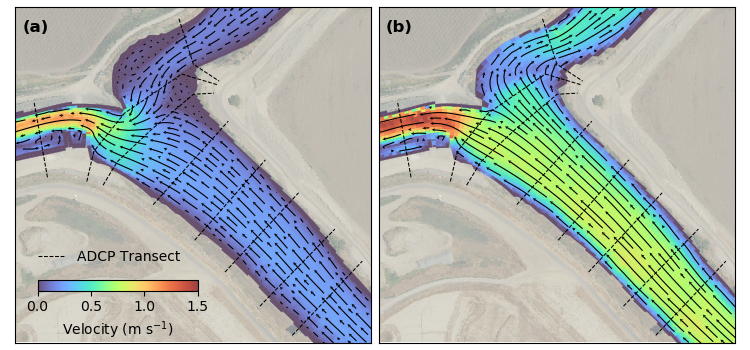

In [102]:
clim=sq.clim
cmap=turbo
fade=0.75
cmap=scmap.transform_color(lambda x: fade*x + (1-fade), cmap)

class QuiverPlotWithBackground(object):
    bathy_contour=False
    legend=True
    cbar=True
    
    ax=None
    dV=1.0 # interval for contours
    sq=None # Stream quiver instance

    zoom=(647076.5624255964, 647510.026008116, 4185590.120652568, 4185998.7323230235)

    cax_rel=[0.03,0.15,0.45,0.03]
    leg_loc=[0.048,0.22]

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        if self.ax is None:
            self.ax=plt.gca()
        self.plot()
    def add_bathy_contour(self):
        demc.contour(np.arange(-10,6,self.dV),ax=self.ax,
                     cmap='gray_r',linewidths=0.2,
                     zorder=-1)

    def fmt_axes(self):
        ax=self.ax
        ax.set_adjustable('datalim')
        ax.axis('equal')
        ax.yaxis.set_visible(0)
        ax.xaxis.set_visible(0)

    def plot(self):
        self.fmt_axes()
        if self.bathy_contour:
            self.add_bathy_contour()
        self.quiver=self.sq.plot_quiver(ax=self.ax)
        self.plot_adcp()
        self.adjust_quiver(self.quiver)
        self.plot_speed()
        self.plot_aerial()
        self.ax.axis(self.zoom)

    def plot_adcp(self):
        # And show the ADCP transect locations, too.
        for t in sel_adcp_transects:
            name=int(t['name'].replace('2018_',''))
            xy=np.array(t['geom'])
            l=self.ax.plot(xy[:,0],xy[:,1],color='k',ls='--',lw=0.75)
            plot_utils.annotate_line(l[0],name,ax=self.ax,norm_position=0.0,rotation=None,
                                    offset_points=5)
        if self.legend:
            self.ax.legend([l[0]],["ADCP Transect"],
                           loc=self.leg_loc,frameon=0)
    def adjust_quiver(self,quiver):
        # black arrows, color in background for speed
        for coll in [quiver['lcoll'],
                     quiver['pcoll']]:
            coll.set_array(None)
            coll.set_color('k')

    def plot_speed(self):
        ccoll=self.sq.g.plot_cells(values=self.sq.Umag,cmap=cmap,clim=clim,ax=self.ax,zorder=-2)
        ccoll.set_edgecolor('face')
        ccoll.set_lw(0.2)
        if self.cbar:
            box=self.ax.get_position()
            self.cax=fig.add_axes([box.xmin+self.cax_rel[0],
                                   box.ymin+self.cax_rel[1],
                                   box.width*self.cax_rel[2], 
                                   box.height*self.cax_rel[3]])
            plt.colorbar(ccoll,cax=self.cax,label='Velocity (m s$^{-1}$)',orientation='horizontal')
    def plot_aerial(self):
        # add aerial image in backgroud
        aerial.plot(ax=self.ax,zorder=-3,alpha=0.5)

        
fig,axs=plt.subplots(1,2,figsize=[7.5, 3.5])
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.02)

q1=QuiverPlotWithBackground(ax=axs[0],sq=sq_flood)
q2=QuiverPlotWithBackground(ax=axs[1],sq=sq_highflow,legend=False,cbar=False)

for ax,lab in zip(axs,"ab"): 
    ax.texts=[]
    ax.text(0.02,0.96,"("+lab+")",va='top',transform=ax.transAxes,fontweight='bold',fontsize=12)

fig.savefig('velocity-overview-panels.png',dpi=200)